<a href="https://colab.research.google.com/github/AlirezaPNouri/BERTEmbedding/blob/main/CollectFeaturesMidFeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Alireza Nouri

Supervisor: prof. Mahmud Shahriar Hossain

database source: https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv 

This is the version that I modified and optimized for my research.
In this version, I collected all embedding and features for all docs

02/ 16/ 2022

In [1]:
#install needed packages
!pip install transformers
!pip install wget
!pip install statistics

     |████████████████████████████████| 3.5 MB 8.5 MB/s 
     |████████████████████████████████| 6.8 MB 80.2 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=920fa61a398850958a94665d8c3f792a94567646d1c8694a8344f08e3f10e6e2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7454 sha256=2268f33db097e7ef8c5834be7355d4c3656f99a9fe2363178f0597c01dab8678
  Stored in directory: /root/.cache/pip/wheels/37/09/e1/49ee45c0ce248a6e9c986aae82d32bbcba09c9f3b9d0c3406a
Successfully built stati

In [2]:
# libraries that are needed to import
import os
import time
import datetime
import sys
import random
import requests
import pickle
import string
import pandas as pd
import numpy as np
from numpy import median, array, exp
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer

In [56]:
# All configs are here
MAX_DATA = 1000 # the maximum data that is extracted from the dataset
max_length = 512 # maximum number of tokens in a document (Bert input)
batch_size = 16 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
epochs = 25 # Number of training epochs (authors recommend between 2 and 4)
seed_val = 42 # Set the seed value all over the place to make this reproducible.
Max_Feature_Size = 20  ## ignore the features after this number
number_of_test_data = 100 # number of data in testing phase
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
jump = 3 # jump size for gradient decent
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
doc_num = 18 # document number for experiiments
threshold_cluster_overlapping = 0.8 # the after jaccard index that we use to consider two clusters are overlapping 
doc_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
 # list of documents' id to extract features


In [4]:
# Function to remove stopwords
def stop_word_remover(list1, stopwords):
  new_list = list()
  for word in list1:
    if word not in stopwords:
      new_list.append(word)
  return new_list
############################################################################  
#function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return len(unique_list)
############################################################################  
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
############################################################################
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
############################################################################
#Function to find similarities
def find_similar(embedding_layers, word_index, original_sentence):
  score_dic = dict()
  # print(len(original_sentence))
  for j in range(1, min(256, len(original_sentence))):
    score_dic[original_sentence[j -1]] =  cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]
    # print('word is {}, score is {}'.format(original_sentence[j -1], cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]))
  return score_dic
############################################################################
# show th t-SNE for the tokens
def tsne_plot(sentences, output):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, embed in zip(sentences, output):
        tokens.append(embed)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
############################################################################
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))
############################################################################
#function to normalize a vector
def normalizer_value(list_):
    temp_list = list()
    for vec in list_[2]:
        value = int(99* ((vec[1] - list_[1]) / (list_[0] - list_[1])) + 1)
        temp_list.append([vec[0],value])
    return temp_list
##########################################################################
#sigmoid function
def sigmoid(vec_):
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

In [5]:
# to check if the GPU is ready to use

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# to tell pytorch that we are going to use GPU

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
# download the dataset as a zip file from the git repo
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv'
res = requests.get(url, allow_redirects=True)
with open('small_dataset_NYT.csv','wb') as file:
    file.write(res.content)
print('Download is done!')


Download is done!


In [7]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1)
print('The original size of dataset is {}'.format(df.shape))
df = df.dropna(how='any', axis=0)

df = df[0:MAX_DATA][[1, 2]]
# Report the number of sentences.
print('Number of training sentences extracted from dataset is {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

df.columns = ['id', 'content']
print('Columns are : {}'.format([name for name in df.columns]))
print('The dimension of the dataset is {}'.format(df.shape))
print(df.sample)

The original size of dataset is (5001, 3)
Number of training sentences extracted from dataset is 1,000

Columns are : ['id', 'content']
The dimension of the dataset is (1000, 2)
<bound method NDFrame.sample of                    id                                            content
0    19900101_0000000  HURRYING through the tunnel at Veterans Stadiu...
1    19900101_0000001  FOR six years, American corporations have been...
2    19900101_0000002  Alcide Chaisson, who is 69 years old and lives...
3    19900101_0000003  Gary Anderson is the third-most accurate kicke...
4    19900101_0000004  The National Bank of Poland is devaluing the P...
..                ...                                                ...
995  19900111_0000997  The greeting card giant Hallmark Cards Inc. sa...
996  19900111_0000998  The police detained 15,000 people today in a s...
997  19900111_0000999  The American retailing operations of the Campe...
998  19900111_0001000  The Ralston Purina Company said it wo

In [8]:
# find the number of classes in the dataset based on the index 7 of their timestamp
sentences = df.content.values
labels = df.id.values
# print(labels)
labels = [int(d[7]) for d in labels]
# print(labels)
class_num = unique(labels)
print('The numeber of classes is {}'.format(class_num))
print('length of data is {} and length of labels is {}'.format(len(sentences), len(labels)))
print('labels are : ', labels)

The numeber of classes is 10
length of data is 1000 and length of labels is 1000
labels are :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joke

In [11]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to us

In [12]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [13]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = class_num, # The number of output labels--2 for binary classification. # here temp is the size of the dataset
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
#Check the variables size in the memory
local_vars = list(locals().items())
for var, obj in local_vars:
  temp = sys.getsizeof(obj)
  if temp >100000:
    print(var, temp/1000000, 'MB')

df 3.949116 MB


In [17]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    embedding_layers = []
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        print(batch[2].shape)
        print(batch[1].shape)
        print(batch[0].shape)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # print(len(outputs))
        # print(outputs[0]) the loss
        # print(len(outputs[1])) the batches
        # print(len(outputs[2])) the embedding layers
        # import numpy as np
        # print(np.shape(outputs[2]))--->(13,)
        # print(np.shape(outputs[2][1])) --->torch.Size([32, 64, 768]) the embedding in the layer one
        # print(np.shape(outputs[2][2]))--->torch.Size([32, 64, 768]) the embedding in the layer two
        # print(len(outputs[2][3]))
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 25 ========
Training...
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 512])
to

In [18]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print(  "")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    #count = 0 # added by Ali
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        logits = outputs[0]
        # print(len(outputs))
        # print(np.shape(outputs[1])) # all embedding layers data
        # print(outputs[1][12]) # access to embedding vectors in layer 13
        #count +=1 added by Ali

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    #print(count)
print("")
print("Training complete!")


Running Validation...
  Accuracy: 0.15
  Validation took: 0:00:02

Training complete!


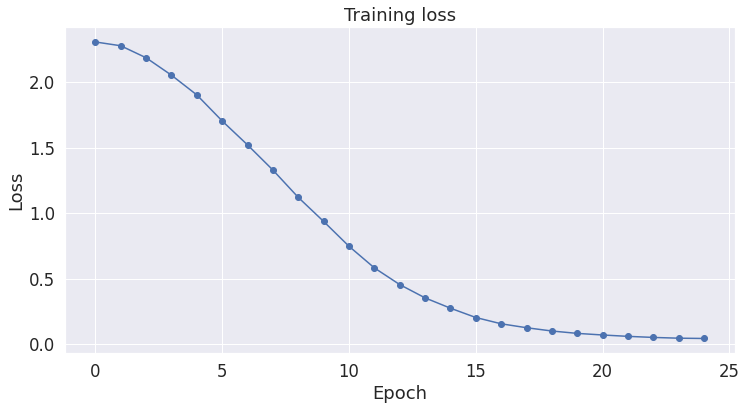

In [19]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [20]:

print('size of testing data is ', df.shape)
print('Number of testing data is ', len(sentences))
print('shape of embedding is ', input_ids.shape)
print('number of labels is ', len(labels))

size of testing data is  (1000, 2)
Number of testing data is  1000
shape of embedding is  torch.Size([1000, 512])
number of labels is  1000


In [21]:
#the same as the maxlen we used in the encoder_plus function

MAX_LEN = max([len(sen) for sen in input_ids])

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = df[0:number_of_test_data]
sentences = sentences[0:number_of_test_data]
labels = labels[0:number_of_test_data]
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
# sentences = new_df.text.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = number_of_test_data  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (1281 > 512). Running this sequence through the model will result in indexing errors


Number of test sentences: 100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [22]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print('np.shape(outputs[0]) ', np.shape(outputs[0]))
  print('np.shape(outputs[1][0]) ', np.shape(outputs[1][0]))
  print('np.shape(outputs[1][1]) ', np.shape(outputs[1][1]))
  print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100 test sentences...
np.shape(outputs[0])  torch.Size([100, 10])
np.shape(outputs[1][0])  torch.Size([100, 512, 768])
np.shape(outputs[1][1])  torch.Size([100, 512, 768])
np.shape(outputs[1][12])  torch.Size([100, 512, 768])
    DONE.


In [23]:
last_layer = outputs[1][12] # the last layer of hidden layers
# print out all the sentences
c = 0
for doc in sentences:
  print('doc {}:'.format(c), doc)
  c += 1

doc 0: HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joked. '

In [24]:
total_word_neighbor_similarity_dict = dict()
for docNum in doc_list:
  print('Document {} is done!'.format(docNum))
  total_tokens = tokenizer.tokenize(sentences[docNum])[0:min(max_length, len(sentences[docNum]))]
  word_neighbor_similarity_dict = dict()
  for ind, word in zip(total_tokens, range(1,len(total_tokens))):
    if ind not in stopwords and ind not in string.punctuation:
      value_list = list()
      temp = sorted(find_similar(last_layer[docNum], word,  tokenizer.tokenize(sentences[docNum])).items(), key=lambda kv: kv[1], reverse=True)
      for d in temp:
        value_list.append(d[1])
      value_list = value_list[1:]
      word_neighbor_similarity_dict[ind] = value_list
  total_word_neighbor_similarity_dict[docNum] = word_neighbor_similarity_dict

Document 1 is done!
Document 2 is done!
Document 3 is done!
Document 4 is done!
Document 5 is done!
Document 6 is done!
Document 7 is done!
Document 8 is done!
Document 9 is done!
Document 10 is done!
Document 11 is done!
Document 12 is done!
Document 13 is done!
Document 14 is done!
Document 15 is done!
Document 16 is done!
Document 17 is done!
Document 18 is done!
Document 19 is done!
Document 20 is done!
Document 21 is done!
Document 22 is done!
Document 23 is done!
Document 24 is done!
Document 25 is done!
Document 26 is done!
Document 27 is done!
Document 28 is done!
Document 29 is done!
Document 30 is done!
Document 31 is done!
Document 32 is done!
Document 33 is done!
Document 34 is done!
Document 35 is done!
Document 36 is done!
Document 37 is done!
Document 38 is done!
Document 39 is done!
Document 40 is done!
Document 41 is done!
Document 42 is done!
Document 43 is done!
Document 44 is done!
Document 45 is done!
Document 46 is done!
Document 47 is done!
Document 48 is done!
D

In [26]:
import pickle
# pickle.dump(total_word_neighbor_similarity_dict, open("total_word_neighbor_similarity_dict.p", "wb"))
# pickle.dump(sentences, open("sentences.p", "wb"))
# total_word_neighbor_similarity_dict = pickle.load(open("total_word_neighbor_similarity_dict.p", "rb"))
# sentences = pickle.load(open("sentences.p", "rb"))


In [27]:
##Calculate the gradient descent of the similarity distribution
# print(word_neighbor_similarity_dict)
total_gradient_word_similarity_dict = dict() 
for docDict, word_neighbor_similarity_dict in total_word_neighbor_similarity_dict.items():
  print('document number is {}'.format(docDict))
  gradient_word_similarity_dict = dict()
  total_size = len(word_neighbor_similarity_dict[list(word_neighbor_similarity_dict.keys())[0]]) # top is an example of tokens in the dictionary to find the length of each vector
  print(total_size-total_size%10)
  length =np.arange(0, total_size)
  for word in word_neighbor_similarity_dict:
    # print(word_neighbor_similarity_dict[word])
    # print(length)
    # new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, len(word_neighbor_similarity_dict['top']), jump)]
    new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, total_size-total_size%jump, jump)]
    tm_list = list()
    for vec in new_list:
      m1, b1 = np.polyfit(np.arange(0, len(vec)), vec, 1)
      tm_list.append(m1)
    gradient_word_similarity_dict[word] = tm_list
  # for ele in gradient_word_similarity_dict.items():
  #   print(ele)
  total_gradient_word_similarity_dict[docDict] = gradient_word_similarity_dict
  #convert dict to a numpy array

document number is 1
150
document number is 2
70
document number is 3
130
document number is 4
90
document number is 5
140
document number is 6
140
document number is 7
130
document number is 8
150
document number is 9
140
document number is 10
140
document number is 11
140
document number is 12
150
document number is 13
150
document number is 14
130
document number is 15
140
document number is 16
130
document number is 17
150
document number is 18
140
document number is 19
20
document number is 20
140
document number is 21
100
document number is 22
140
document number is 23
130
document number is 24
150
document number is 25
140
document number is 26
140
document number is 27
140
document number is 28
140
document number is 29
140
document number is 30
140
document number is 31
130
document number is 32
130
document number is 33
140
document number is 34
120
document number is 35
130
document number is 36
120
document number is 37
140
document number is 38
130
document number is 39
15

In [28]:
for key_, val_ in total_gradient_word_similarity_dict.items():
  temp_dict = dict()
  for key1_, val1_ in val_.items():
    tmp_ = np.array(list(val1_))[0:Max_Feature_Size]
    temp_dict[key1_] = sigmoid(tmp_)
  total_gradient_word_similarity_dict[key_] = temp_dict

In [29]:
#clustering by kmean. it creates different clusters in each iteration
total_all_clusters = dict()
total_all_centroids = dict()
for docNum, gradient_word_similarity_dict in total_gradient_word_similarity_dict.items():
  # print('Document {} clustering is done!'.format(docNum))
  dic_per_doc = dict()
  cent_per_doc = dict()
  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=100,)
    cluster_labels = clusterer.fit_predict(list(gradient_word_similarity_dict.values()))
    centers = clusterer.cluster_centers_
    cent_per_doc[n_clusters] = centers
    dic_per_doc[n_clusters] = cluster_labels
  total_all_clusters[docNum] = dic_per_doc
  total_all_centroids[docNum] = cent_per_doc

In [80]:
#create a total clusters sorted dictionary
total_docs_clusters = dict()
for docNum in doc_list:
  # total_all_centroids[docNum]
  temp_cluster = total_all_clusters[docNum]
  # total_gradient_word_similarity_dict[docNum]
  dic_for_clustering = dict()
  for n_cluster in range_n_clusters:
    temp_dict = dict()
    for la in range(0, n_cluster):
      temp_list = list()
      for label_, value_ in zip(temp_cluster[n_cluster],total_gradient_word_similarity_dict[docNum].items()):
        if label_ == la:
          temp_list.append(value_)
      temp_dict[la]=temp_list
    dic_for_clustering[n_cluster] = temp_dict
  total_docs_clusters[docNum] = dic_for_clustering
  
    
      
          
#structure of total_doc_clusters
# {doc_number{2: {0: [list_of_words_in_cluster_0_if_we_have_2_clusters (Their_vectors)], 1: [list_of_words_in_cluster_1_if_we_have_2_clusters],...}, 3: {0: [list_of_words_in_cluster_0_if_we_have_3_clusters], 1: [list_of_words_in_cluster_1_if_we_have_3_clusters],...}}




In [100]:
#add similarity to centroid feature to the words
# print(total_all_centroids[1])
# total_doc_clusters_w_similarity = 
total_doc_clusters_w_similarity = dict()
for docNum in doc_list:
  temp_doc = total_docs_clusters[docNum]
  temp_dic_clusters = dict()
  for cat_ in temp_doc.keys():
    sub_doc = temp_doc[cat_]
    temp_dict = dict()
    for catNum in sub_doc.keys():
      temp_list = list()
      for word_ in sub_doc[catNum]:
        sim_val = cosine_similarity([word_[1]], [total_all_centroids[docNum][cat_][catNum]])
        temp_list.append([word_[0], word_[1], sim_val[0][0]])
      temp_dict[catNum] = temp_list
    temp_dic_clusters[cat_] = temp_dict
  total_doc_clusters_w_similarity[docNum] = temp_dic_clusters
  print('Document {} is done!'.format(docNum))
  ##total_doc_clusters_w_similarity structure is : {doc1: {how_many_clustering:{cluster_number :{ [word, vector_of_word, similarity]}}}
      

Document 1 is done!
Document 2 is done!
Document 3 is done!
Document 4 is done!
Document 5 is done!
Document 6 is done!
Document 7 is done!
Document 8 is done!
Document 9 is done!
Document 10 is done!
Document 11 is done!
Document 12 is done!
Document 13 is done!
Document 14 is done!
Document 15 is done!
Document 16 is done!
Document 17 is done!
Document 18 is done!
Document 19 is done!
Document 20 is done!
Document 21 is done!
Document 22 is done!
Document 23 is done!
Document 24 is done!
Document 25 is done!
Document 26 is done!
Document 27 is done!
Document 28 is done!
Document 29 is done!
Document 30 is done!
Document 31 is done!
Document 32 is done!
Document 33 is done!
Document 34 is done!
Document 35 is done!
Document 36 is done!
Document 37 is done!
Document 38 is done!
Document 39 is done!
Document 40 is done!
Document 41 is done!
Document 42 is done!
Document 43 is done!
Document 44 is done!
Document 45 is done!
Document 46 is done!
Document 47 is done!
Document 48 is done!
D

In [133]:
# print(total_doc_clusters_w_similarity[1])
# doc_list = [1]
total_doc_word_groups = dict()
for docNum in doc_list:
  docs_clusters = total_doc_clusters_w_similarity[docNum]
  # print(docs_clusters)
  temp_list_word_groups = list()
  for cluster_num in list(docs_clusters.keys())[:-1]:
    for cluster in range(0, cluster_num):
      for next_cluster in range(0, cluster_num+1):
        cl1 = list()
        cl1_w_sim = dict()
        cl2 = list()
        cl2_w_sim = dict()
        joint_list = list()
        for item in docs_clusters[cluster_num][cluster]:
          cl1.append(item[0])
          cl1_w_sim[item[0]] =  item[2]
        for another_item in docs_clusters[cluster_num+1][next_cluster]:
          cl2.append(another_item[0])
          cl2_w_sim[another_item[0]] = another_item[2]
        # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
        jac_val = jaccard_similarity(cl1, cl2)
        if jac_val > threshold_cluster_overlapping:
          jnt_list = list(set(cl1).intersection(cl2))
          dict_vocab = dict()
          for el in jnt_list:
            dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

          temp_list_word_groups.append([dict_vocab ,jac_val])
  

  total_doc_word_groups[docNum] = temp_list_word_groups
  # print('Document {} is done!'.format(docNum))

In [134]:
print(total_doc_word_groups[1])
#normalize the values of similarity and change it to range of 1 -10. 10 is most similar ones

normalized_total_doc_word_groups = dict()
for docNum in doc_list:
  temp_list = list()
  for grp in total_doc_word_groups[docNum]:
    # print(grp[0])
    min_ = 100 * min(grp[0].values())
    max_ = 100 * max(grp[0].values())
    print(min_, '   ', max_)
    for el in grp[0].keys():
      grp[0][el] = int(((grp[0][el]-min_)/(max_-min_+1)))



print(total_doc_word_groups[1])





[[{'justified': 0.9995336302104468, 'retained': 0.9989202338069602, 'research': 0.9995487095269358, 'jerry': 0.99906493303182, 'growth': 0.9998820161629265, 'invested': 0.9993354359190252, 'us': 0.9990973787168488, 'concept': 0.9987370926073577, 'machinery': 0.9997692388759284, 'days': 0.9991885591250141, 'national': 0.9995503642715259, 'aircraft': 0.9992726124882969, 'wan': 0.99965905014524, 'buying': 0.9997201217725312, 'money': 0.9996995452158542, 'assistant': 0.9993488073809467, 'putting': 0.9991245533204098, 'gamble': 0.9998696441926096, 'white': 0.9998029694857539, 'mountain': 0.9997556810015211, 'indeed': 0.9995291328400878, 'stock': 0.999688412066262, 'sure': 0.9991945624564998, 'equipment': 0.9996975101454565, 'use': 0.999655780870209, 'idea': 0.9993029580104869, 'american': 0.9997954518477443, '##backs': 0.999843652701884, 'mary': 0.999756024208595, 'companies': 0.9997604965539904, 'earn': 0.999516104926251, 'important': 0.999589876637693, 'consequences': 0.9994154158813249, 

In [57]:
# doc_list = [1]
total_doc_word_groups = dict()
for docNum in doc_list:
  docs_clusters = total_docs_clusters[docNum]
  # print(docs_clusters)
  temp_list_word_groups = list()
  for cluster_num in list(docs_clusters.keys())[:-1]:
    for cluster in range(0, cluster_num):
      for next_cluster in range(0, cluster_num+1):
        cl1 = list()
        cl2 = list()
        for item in docs_clusters[cluster_num][cluster]:
          cl1.append(item[0])
        for another_item in docs_clusters[cluster_num+1][next_cluster]:
          cl2.append(another_item[0])
        # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
        jac_val = jaccard_similarity(cl1, cl2)
        if jac_val > threshold_cluster_overlapping:
          temp_list_word_groups.append([list(set(cl1).intersection(cl2)) ,jac_val])
  

  total_doc_word_groups[docNum] = temp_list_word_groups
  print('Document {} is done!'.format(docNum))
          
    


Document 1 is done!
Document 2 is done!
Document 3 is done!
Document 4 is done!
Document 5 is done!
Document 6 is done!
Document 7 is done!
Document 8 is done!
Document 9 is done!
Document 10 is done!
Document 11 is done!
Document 12 is done!
Document 13 is done!
Document 14 is done!
Document 15 is done!
Document 16 is done!
Document 17 is done!
Document 18 is done!
Document 19 is done!
Document 20 is done!
Document 21 is done!
Document 22 is done!
Document 23 is done!
Document 24 is done!
Document 25 is done!
Document 26 is done!
Document 27 is done!
Document 28 is done!
Document 29 is done!
Document 30 is done!
Document 31 is done!
Document 32 is done!
Document 33 is done!
Document 34 is done!
Document 35 is done!
Document 36 is done!
Document 37 is done!
Document 38 is done!
Document 39 is done!
Document 40 is done!
Document 41 is done!
Document 42 is done!
Document 43 is done!
Document 44 is done!
Document 45 is done!
Document 46 is done!
Document 47 is done!
Document 48 is done!
D

In [93]:
print(total_doc_clusters_w_similarity[1])

{2: {0: [['american', array([0.27587066, 0.46721251, 0.46008305, 0.4938665 , 0.48675641,
       0.49497583, 0.48296206, 0.49576635, 0.49662939, 0.48152058,
       0.49973137, 0.49185001, 0.4965595 , 0.4954854 , 0.49865424,
       0.49778803, 0.4947945 , 0.48002785, 0.48725005, 0.49539916]), array([[0.99975305]])], ['corporations', array([0.3232964 , 0.40074693, 0.40888746, 0.42167403, 0.48337634,
       0.47455015, 0.49006653, 0.48339977, 0.49725061, 0.49751298,
       0.48029606, 0.49331679, 0.49273668, 0.47091987, 0.4973122 ,
       0.48893837, 0.49547826, 0.49493842, 0.49270841, 0.47400382]), array([[0.99911917]])], ['buying', array([0.2824276 , 0.44096306, 0.49237871, 0.44506285, 0.47226236,
       0.4908942 , 0.49496532, 0.49082364, 0.49119629, 0.49609524,
       0.48588193, 0.49367309, 0.49481057, 0.49861876, 0.4980404 ,
       0.49874004, 0.49801945, 0.49285034, 0.49014603, 0.4924223 ]), array([[0.99972012]])], ['stock', array([0.29444155, 0.43613801, 0.46739389, 0.43846217, 0.4

Word clouds

In [71]:
#display the word clud for each document
for docNum in doc_list:
  word_list = set()
  print('The original dict is {}'.format(total_doc_word_groups[docNum]))
  





In [ ]:
word_list = set()
print('The original dict is {}'.format(overlaped_clusters))
for el in overlaped_clusters:
  print(' the layer {}'.format(el))
  for cl in overlaped_clusters[el]:
    print(overlaped_clusters[el][cl])
    word_list.update(overlaped_clusters[el][cl])
# final_list = stop_word_remover(word_list, stopwords) # the stopwords are removed from the cluster before applying Jaccard Index
print('Final list of words is {}'.format(word_list))

In [ ]:
print(total_clusters_with_similarities)
print(selected_clusters)
cluster_list = list()
for vec in selected_clusters:
  tmp_list = list()
  garbage_list = list()
  min_ = 1
  max_ = 0
  for el in total_clusters_with_similarities[vec[0],vec[1]] + total_clusters_with_similarities[vec[0]+1,vec[2]]:
    if el[0] not in stopwords and len(el[0])>2:
      if el[0] not in garbage_list:
        garbage_list.append(el[0])
      else:
        if el[1]>max_:
          max_ = el[1]
        if el[1]< min_:
          min_ = el[1]
        tmp_list.append(el)
  cluster_list.append([max_, min_, tmp_list])
  
print(cluster_list)

In [ ]:
test = [0.9825819266584156, 0.40577821379719814, [('party', 0.9825819266584156), ('##s', 0.982141010637889), ('been', 0.9810166043529759), ('land', 0.9805601133499222), ('##sman', 0.9781751472033356), ('freedoms', 0.9772748648464267), ('seeking', 0.9763145100487863), ('urging', 0.9746435605927545), ('years', 0.9746009643723771), ('after', 0.973530972422985), ('are', 0.9720529116828479), ('communists', 0.9690921614798568), ('eager', 0.9683786039699253), ('risen', 0.9675966607368819), ('##aus', 0.9631290844128872), ('high', 0.9631161742863688), ('those', 0.9594043878965094), ('##anian', 0.9578385805511627), ('profile', 0.9561506895082291), ('political', 0.9560653481773054), ('figures', 0.9496140826077256), ('itself', 0.9487595451882704), ('##ness', 0.9443216591277065), ('ranks', 0.9428484761365006), ('once', 0.9403937531168767), ('disgrace', 0.9381102314137233), ('have', 0.9329694816705608), ('country', 0.9262983110299957), ('within', 0.9250182232086733), ('intellectuals', 0.909219201146454), ('like', 0.9091980365524924), ('since', 0.908714334355933), ('wary', 0.8955317389031143), ('detained', 0.8811489793291609), ('message', 0.8755032647684652), ('dec', 0.8738373430789401), ('this', 0.8657763533542258), ('top', 0.8412999755732483), ('open', 0.7557810605008625), ('uprising', 0.7496371898464387), ('##escu', 0.725510582254375), ('flourished', 0.6922523492887434), ('among', 0.6276936069067001), ('president', 0.6098474794942315), ('appear', 0.5694084201742404), ('newspapers', 0.5653333081029144), ('##r', 0.5363174104642561), ('swirl', 0.5219041685041015), ('##vor', 0.5027227695065126), ('national', 0.40577821379719814)]]
print(cluster_list)

cluster_list_ = [normalizer_value(ve) for ve in cluster_list]
print(cluster_list_)

In [ ]:
from matplotlib.font_manager import list_fonts
list_word_cloud = list()
for el in cluster_list_:
  # print(el)
  temp_dict = dict()
  for ele in el:
    # print(ele[0])
    if ele[0].startswith('#'):
      pass
    else:
      temp_dict[ele[0]] = ele[1]
  list_word_cloud.append(temp_dict)


print(list_word_cloud)

In [ ]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
for item in list_word_cloud:
  wordcloud = WordCloud(collocations=True, background_color= 'White').generate_from_frequencies(item)
  
  #plot the wordcloud object
  print(item.keys())
  plt.imshow(wordcloud, interpolation='bilInear')
  plt.axis('off')
  plt.show()
  print('---------------------------------')